In [1]:
import os, glob
from pathlib import Path
from tqdm.notebook import tqdm
tqdm.pandas()

from datetime import datetime
from itertools import accumulate
from collections import Counter

import numpy as np
import pandas as pd

from tools.faster_rcnn import *

import matplotlib.pyplot as plt
%matplotlib inline

from tools.utils import *

import plotly.graph_objects as go

import dash
from dash import dcc
from dash import html

# OKVQA - Investigating Visual data

This notebook examines the OKVQA dataset Visual side. The attributes and building of the dataset follows the configuration used by the widely applied [VQA dataset](https://visualqa.org/download.html). 

## 1) Load data and initial investigation
We start by loading the OKVQA datasets that we analyzed and modified a bit in the `okvqa_test.ipynb` file. Furthermore, we load the image file names!

In [2]:
# path to okvqa dataset (from text-investigation)
filename = 'OKVQA_text.json'
data_path = Path(os.getcwd()) / 'data'

okvqa = {}
okvqa['full'] = pd.read_json(data_path/filename)
okvqa['full'].head()

,image_id,question_id,answer_type,question_type,confidence,question_str,question_tokens,all_answers,answers,image_name,feature_path,annotator_agreement_cos
0,51606,516065,other,four,3,What is the hairstyle of the blond called?,"[what, is, the, hairstyle, of, the, blond, cal...","[pony tail, pony tail, pony tail, pony tail, p...","[pony tail, pony tail, pony tail, pony tail, p...",COCO_train2014_000000051606,COCO_train2014_000000051606.npy,0.977160
1,81721,817215,other,seven,5,How old do you have to be in canada to do this?,"[how, old, do, you, have, to, be, in, canada, ...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18]","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18]",COCO_train2014_000000081721,COCO_train2014_000000081721.npy,NaN
2,480208,4802085,other,four,2,Can you guess the place where the man is playing?,"[can, you, guess, the, place, where, the, man,...","[aspen, aspen, mountain, mountain, mountain, m...","[aspen, aspen, mountain, mountain, mountain, m...",COCO_train2014_000000480208,COCO_train2014_000000480208.npy,0.974979
3,570618,5706185,other,one,2,Which rail company is named after a town in ne...,"[which, rail, company, is, named, after, a, to...","[santa fe, santa fe, santa fe, santa fe, new e...","[santa fe, santa fe, santa fe, santa fe, new e...",COCO_train2014_000000570618,COCO_train2014_000000570618.npy,0.960305
4,478903,4789035,other,seven,2,Is the boy swimming or doing another water act...,"[is, the, boy, swimming, or, doing, another, w...","[another activity, another activity, another a...","[another activity, another activity, another a...",COCO_train2014_000000478903,COCO_train2014_000000478903.npy,0.955901


In [3]:
# load image filenames
# Load features
data_path = Path.home() / '.cache/torch/mmf/data/datasets/okvqa/defaults/images'

image_names = glob.glob(data_path.as_posix()+'/*.jpg')

Let's try to find out how many unique images that are in the data!

In [4]:
okvqa['full'].image_name.unique().__len__()

14031

This is shorter than the full dataset that is of size 14055, which is due to some images having 2 associated questions.

In [5]:
sorted(Counter(okvqa['full'].image_name).items(), key=lambda x: x[1], reverse=True)

[('COCO_train2014_000000318924', 2),
 ('COCO_train2014_000000120179', 2),
 ('COCO_train2014_000000526713', 2),
 ('COCO_train2014_000000404990', 2),
 ('COCO_train2014_000000525212', 2),
 ('COCO_train2014_000000556497', 2),
 ('COCO_train2014_000000319818', 2),
 ('COCO_train2014_000000194159', 2),
 ('COCO_train2014_000000555102', 2),
 ('COCO_train2014_000000512950', 2),
 ('COCO_train2014_000000151658', 2),
 ('COCO_val2014_000000572399', 2),
 ('COCO_val2014_000000236542', 2),
 ('COCO_val2014_000000058472', 2),
 ('COCO_val2014_000000191585', 2),
 ('COCO_val2014_000000318671', 2),
 ('COCO_val2014_000000084643', 2),
 ('COCO_val2014_000000536375', 2),
 ('COCO_val2014_000000553942', 2),
 ('COCO_val2014_000000282037', 2),
 ('COCO_val2014_000000519475', 2),
 ('COCO_val2014_000000558253', 2),
 ('COCO_val2014_000000382307', 2),
 ('COCO_val2014_000000055299', 2),
 ('COCO_train2014_000000051606', 1),
 ('COCO_train2014_000000081721', 1),
 ('COCO_train2014_000000480208', 1),
 ('COCO_train2014_000000570

## 2) Object detection on Images

We will analyze the images by applying an object detection model to each image and then analyzing the item content of images. For simplicity, we use a pretrained Faster-RCNN object detection model with a ResNet50 structure for object detection, as it is similar to how we model the VQA task. The code is taken with inspiration from [here.](https://haochen23.github.io/2020/04/object-detection-faster-rcnn.html#.YksEji0Ykb0)

In [77]:
# load model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# set to evaluation mode
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

We show an example of the object detection before applying it "blindly" to all images in the OKVQA dataset.

In [9]:
filename = image_names[0]

# show detected objects
detect_object(model, filename, confidence=0.7)#, figsize=(10,15))

Now we apply the object detection model on all images in the OKVQA dataset. This is done with a threshold of 70% certainty of the object.

In [9]:
image_names = image_names[:5]

In [10]:
image_labels = {}
for filename in tqdm(image_names):
    # predict / detect objects in image
    _, pred_class = get_prediction(model, filename, confidence=0.7)
    
    # save labels
    img_name = filename.split(os.sep)[-1].split(".")[0]
    image_labels[img_name] = pred_class


In [ ]:
image_items = [image_labels.get(name, []) for name in tqdm(okvqa['full'].image_name)]
okvqa['full']['image_objects'] = image_items

Save the dataframe for later use!

In [73]:
okvqa['full'].to_json(f'data/OKVQA_object_{str(datetime.now())}.json')

## 3) Load pre-defined data

In [6]:
# path to okvqa dataset (from text-investigation)
filename = 'OKVQA_object.json'
data_path = Path(os.getcwd()) / 'data'

okvqa = {}
okvqa['full'] = pd.read_json(data_path/filename)
okvqa['full'].head()

,image_id,question_id,answer_type,question_type,confidence,question_str,question_tokens,all_answers,answers,image_name,feature_path,annotator_agreement_cos,image_objects
0,51606,516065,other,four,3,What is the hairstyle of the blond called?,"[what, is, the, hairstyle, of, the, blond, cal...","[pony tail, pony tail, pony tail, pony tail, p...","[pony tail, pony tail, pony tail, pony tail, p...",COCO_train2014_000000051606,COCO_train2014_000000051606.npy,0.977160,"[person, person, tennis racket, chair]"
1,81721,817215,other,seven,5,How old do you have to be in canada to do this?,"[how, old, do, you, have, to, be, in, canada, ...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18]","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18]",COCO_train2014_000000081721,COCO_train2014_000000081721.npy,NaN,"[person, wine glass, person, wine glass, perso..."
2,480208,4802085,other,four,2,Can you guess the place where the man is playing?,"[can, you, guess, the, place, where, the, man,...","[aspen, aspen, mountain, mountain, mountain, m...","[aspen, aspen, mountain, mountain, mountain, m...",COCO_train2014_000000480208,COCO_train2014_000000480208.npy,0.974979,"[person, backpack, skis]"
3,570618,5706185,other,one,2,Which rail company is named after a town in ne...,"[which, rail, company, is, named, after, a, to...","[santa fe, santa fe, santa fe, santa fe, new e...","[santa fe, santa fe, santa fe, santa fe, new e...",COCO_train2014_000000570618,COCO_train2014_000000570618.npy,0.960305,[train]
4,478903,4789035,other,seven,2,Is the boy swimming or doing another water act...,"[is, the, boy, swimming, or, doing, another, w...","[another activity, another activity, another a...","[another activity, another activity, another a...",COCO_train2014_000000478903,COCO_train2014_000000478903.npy,0.955901,"[person, surfboard]"


In [7]:
okvqa['full'].shape

(14055, 13)

We check whether there are certain images where the object detection model did not find any objects - if so, they are removed from the further analyses. 

In [8]:
# find images where no objects were detected
no_objects = okvqa['full'].image_objects.apply(lambda x: x.__len__() == 0)
print(f"Number of QA-pairs without clear objects on the image: {no_objects.sum()}")

# drop images where no objects were detected
okvqa['full'] = okvqa['full'][-no_objects].reset_index().drop('index', axis=1)
okvqa['full'].head()

Number of QA-pairs without clear objects on the image: 172


,image_id,question_id,answer_type,question_type,confidence,question_str,question_tokens,all_answers,answers,image_name,feature_path,annotator_agreement_cos,image_objects
0,51606,516065,other,four,3,What is the hairstyle of the blond called?,"[what, is, the, hairstyle, of, the, blond, cal...","[pony tail, pony tail, pony tail, pony tail, p...","[pony tail, pony tail, pony tail, pony tail, p...",COCO_train2014_000000051606,COCO_train2014_000000051606.npy,0.977160,"[person, person, tennis racket, chair]"
1,81721,817215,other,seven,5,How old do you have to be in canada to do this?,"[how, old, do, you, have, to, be, in, canada, ...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18]","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18]",COCO_train2014_000000081721,COCO_train2014_000000081721.npy,NaN,"[person, wine glass, person, wine glass, perso..."
2,480208,4802085,other,four,2,Can you guess the place where the man is playing?,"[can, you, guess, the, place, where, the, man,...","[aspen, aspen, mountain, mountain, mountain, m...","[aspen, aspen, mountain, mountain, mountain, m...",COCO_train2014_000000480208,COCO_train2014_000000480208.npy,0.974979,"[person, backpack, skis]"
3,570618,5706185,other,one,2,Which rail company is named after a town in ne...,"[which, rail, company, is, named, after, a, to...","[santa fe, santa fe, santa fe, santa fe, new e...","[santa fe, santa fe, santa fe, santa fe, new e...",COCO_train2014_000000570618,COCO_train2014_000000570618.npy,0.960305,[train]
4,478903,4789035,other,seven,2,Is the boy swimming or doing another water act...,"[is, the, boy, swimming, or, doing, another, w...","[another activity, another activity, another a...","[another activity, another activity, another a...",COCO_train2014_000000478903,COCO_train2014_000000478903.npy,0.955901,"[person, surfboard]"


### 3) Analyze Content of Images



In [11]:
# number of objects and unique objects
okvqa['full']['num_objects'] = okvqa['full'].image_objects.apply(lambda x: x.__len__())
okvqa['full']['unique_objects'] = okvqa['full'].image_objects.apply(lambda x: np.unique(x))
okvqa['full']['num_unique'] = okvqa['full'].image_objects.apply(lambda x: np.unique(x).__len__())

In [62]:

# define plotting function
def LogAndLinearHist(data, xlabel='', figsize=((8,3)), dpi=100):
    min_val, max_val = (min(data), max(data))
    
    # compute bins
    log_bins = np.logspace(min_val if min_val == 0 else np.log10(min_val), np.log10(max_val), 31)
    lin_bins = np.linspace(min_val, max_val, 31)

    # create histogram values
    hist_log, edges_log = np.histogram(data.values, log_bins, density=True)
    hist_lin, edges_lin = np.histogram(data.values, lin_bins)

    # determine x-values
    log_x = (edges_log[1:] + edges_log[:-1]) / 2.
    lin_x = (edges_lin[1:] + edges_lin[:-1]) / 2.

    xx, yy = zip(*[(i,j) for (i,j) in zip(log_x, hist_log) if j > 0])
    
    # plot figure
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize, dpi=dpi)

    # linear scale plot
    ax[0].plot(lin_x, hist_lin, marker='.', alpha=0.5)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('count')
    ax[0].set_title('linear scale')
    #ax[0].legend()

    # log-log scale plot
    ax[1].plot(xx, yy, marker='.', alpha=0.5)
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('probability density')
    ax[1].set_title('log-log scale')
    #ax[1].legend()

    # show figure
    plt.tight_layout()
    plt.show()

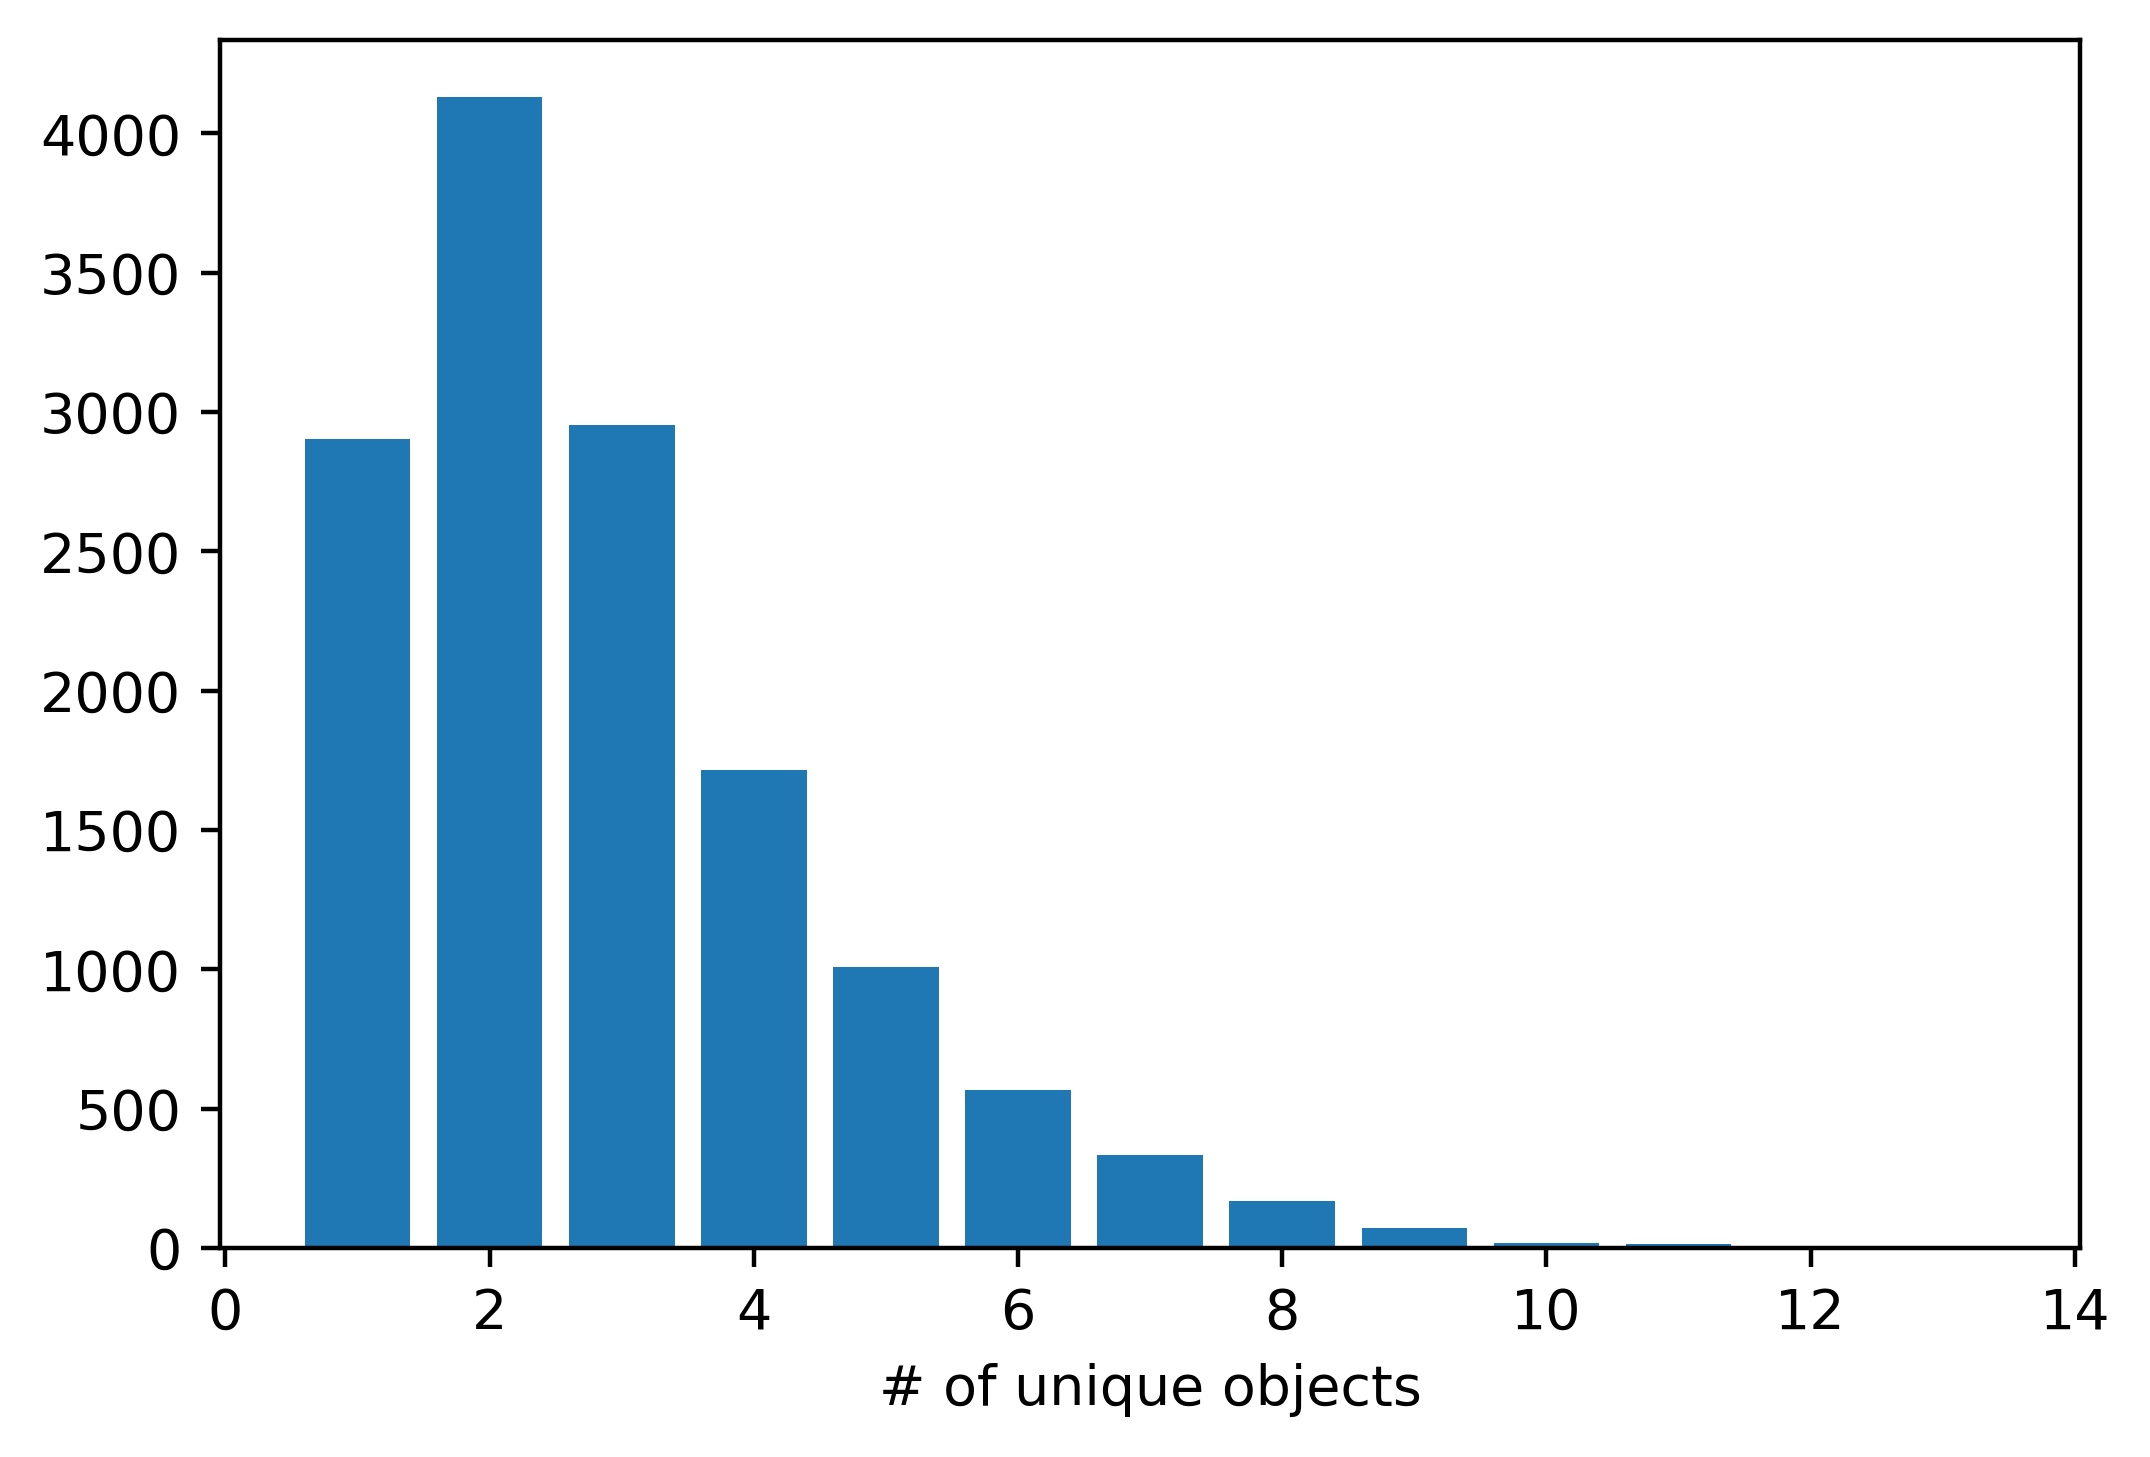

In [58]:
plt.figure(dpi=400)
ticks, heights = list(zip(*sorted(Counter(okvqa['full'].num_unique).items(), key=lambda x: x[0])))
plt.bar(ticks, heights)
plt.xlabel('# of unique objects')
plt.show()

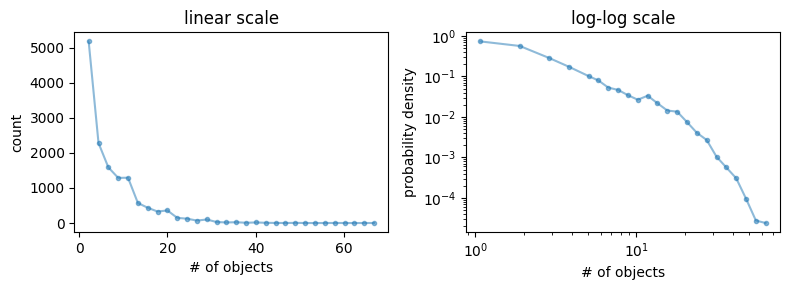

In [63]:
LogAndLinearHist(okvqa['full'].num_objects, xlabel='# of objects')

In [ ]:
# SHOW THE IMAGE WITH MOST OBJECTS DETECTED

In [1]:
filename = okvqa['full'][okvqa['full'].num_objects == 68].image_name.iloc[0]

# show detected objects
detect_object(model, filename, confidence=0.7)#, figsize=(10,15))

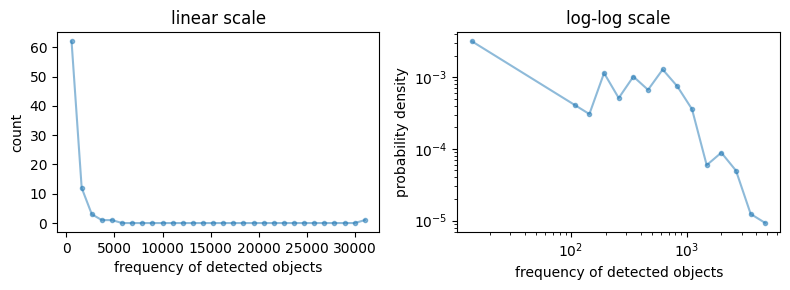

,object,count
0,person,31586
1,car,4909
2,chair,3614
3,bottle,2850
4,book,2542
...,...,...
75,microwave,175
76,fire hydrant,165
77,parking meter,123
78,toaster,16


In [64]:
all_objects = okvqa['full'].image_objects.apply(pd.Series).stack().reset_index(drop=True)
all_objects = pd.DataFrame(sorted(Counter(all_objects).items(), key=lambda x: x[1], reverse=True), columns=['object','count'])

LogAndLinearHist(all_objects['count'], xlabel='frequency of detected objects')
all_objects

Let's try to get some standard infromation about the object, such as the average number of objects on an image, the distribution of number of each unique object-type, etc..

In [71]:
import plotly.express as px

fig = px.pie(all_objects[:20], values='count', names='object', title='Distribution of the top 20 oquestion types in OKVQA')
fig.show()

In [34]:
# mean number of objects on an image
okvqa['full'].num_objects.mean()

7.099618238132968

In [36]:
# mean number of unique objects on an image
okvqa['full'].num_unique.mean()

2.8830944320391847

Let's instead look at how much the questions, answers and image objects have in common. We will check how many of the image objects that (across all questions and answers) occur in the text.

In [93]:
all_answers = okvqa['full'].answers.apply(pd.Series).stack().reset_index(drop=True).unique()
all_q_tokens = okvqa['full'].question_tokens.apply(pd.Series).stack().reset_index(drop=True).unique()

In [95]:
# objects on images that are mentioned in answers
relevant = set(all_answers)
sum([some_object in relevant for some_object in all_objects['object']])

72

In [96]:
# objects on images that are mentioned in questions
relevant = set(all_q_tokens)
sum([some_object in relevant for some_object in all_objects['object']])

62

Find out whether the objects occurring on images are mentioned in question and answers, respectively, for each IQ pair.

In [84]:
object_in_question = []
object_in_answers = []
for i, subframe in tqdm(okvqa['full'].iterrows(), total=okvqa['full'].__len__()):
    temp = pd.DataFrame(subframe).T
    question_tokens = list(temp.question_tokens)[0]
    answer_tokens = list(temp.answers)[0]
    object_tokens = list(temp.image_objects)[0]
    
    object_in_question.append(np.mean([some_object in question_tokens for some_object in object_tokens]))
    object_in_answers.append(np.mean([some_object in answer_tokens for some_object in object_tokens]))

okvqa['full']['object_in_question'] = object_in_question
okvqa['full']['object_in_answers'] = object_in_answers

In [105]:
okvqa['full'].object_in_question.describe()

count    13883.000000
mean         0.085607
std          0.231072
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: object_in_question, dtype: float64

In [106]:
okvqa['full'].object_in_answers.describe()

count    13883.000000
mean         0.040236
std          0.162965
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: object_in_answers, dtype: float64

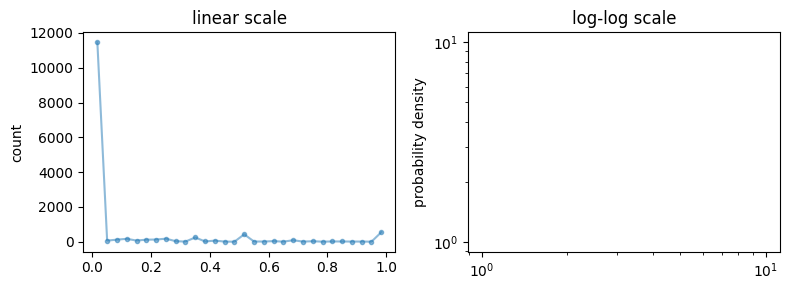

In [97]:
LogAndLinearHist(okvqa['full'].object_in_question)#, xlabel='frequency of detected objects')

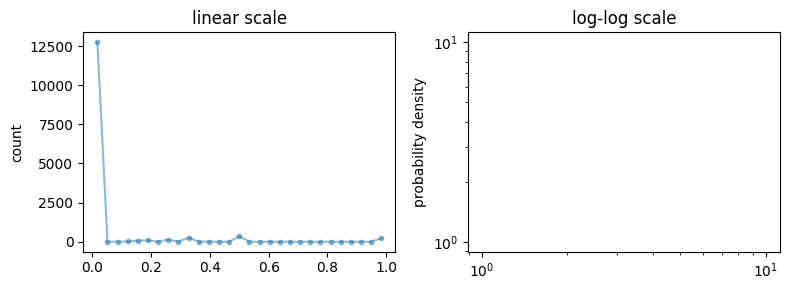

In [102]:
LogAndLinearHist(okvqa['full'].object_in_answers)#, xlabel='frequency of detected objects')

In [106]:
okvqa['full'][['object_in_answer', 'object_in_question']].describe()

,object_in_answer,object_in_question
count,13883.000000,13883.000000
mean,0.039399,0.088270
std,0.154029,0.226994
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


So it is quite clear, that image objects do not in general directly occur in the text - both for quetsions and answers. This suggest a reasonable level of complexity, as it suggests that questions are not about just understanding the visual content.